In [4]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
dta = sm.datasets.fair.load_pandas().data

In [6]:
dta['affair'] = (dta.affairs > 0).astype(int)
y, X = dmatrices('affair ~ rate_marriage + age + yrs_married + children +  religious + educ + C(occupation) + C(occupation_husb)', dta, return_type="dataframe")

In [9]:
X = X.rename(columns = {'C(occupation)[T.2.0]':'occ_2',
'C(occupation)[T.3.0]':'occ_3',
'C(occupation)[T.4.0]':'occ_4',
'C(occupation)[T.5.0]':'occ_5',
'C(occupation)[T.6.0]':'occ_6',
'C(occupation_husb)[T.2.0]':'occ_husb_2',
'C(occupation_husb)[T.3.0]':'occ_husb_3',
'C(occupation_husb)[T.4.0]':'occ_husb_4',
'C(occupation_husb)[T.5.0]':'occ_husb_5',
'C(occupation_husb)[T.6.0]':'occ_husb_6'})
y = np.ravel(y)

In [14]:
import statsmodels.api as sm
logit_model=sm.Logit(y,X)
results=logit_model.fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.542911
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                 6366
Model:                          Logit   Df Residuals:                     6349
Method:                           MLE   Df Model:                           16
Date:                Tue, 23 Apr 2019   Pseudo R-squ.:                  0.1365
Time:                        16:52:09   Log-Likelihood:                -3456.2
converged:                       True   LL-Null:                       -4002.5
                                        LLR p-value:                1.534e-222
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         2.9708      0.572      5.192      0.000       1.849       4.092
occ_2             0.

The p-values for six of the variables are smaller than 0.05 and for ten variables it is greater, therefore, we will remove them.
(Removing occ_6 as subsequent analysis gave p>0.05)

In [56]:
cols=['occ_5','rate_marriage','age','yrs_married','religious']
x=X[cols]

In [57]:
x.head()

,occ_5,rate_marriage,age,yrs_married,religious
0,0.0,3.0,32.0,9.0,3.0
1,0.0,3.0,27.0,13.0,1.0
2,0.0,4.0,22.0,2.5,1.0
3,1.0,4.0,37.0,16.5,3.0
4,0.0,5.0,27.0,9.0,1.0


In [58]:
logit_model = sm.Logit(y,x)
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.562140
         Iterations 5
                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.106      
Dependent Variable: y                AIC:              7167.1695  
Date:               2019-04-23 17:55 BIC:              7200.9631  
No. Observations:   6366             Log-Likelihood:   -3578.6    
Df Model:           4                LL-Null:          -4002.5    
Df Residuals:       6361             LLR p-value:      3.2454e-182
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     5.0000                                        
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
occ_5              0.4556   0.0852   5.3459 0.0000  0.2886  0.6226
rate_marriage     -0.4996   0.0266 -18.7942 0.0000 -0

<H3> Train test Split </H3>

In [59]:
x_train,x_test,y_train,y_test= train_test_split(x,y, test_size=0.3, random_state=0)

<H3> Logistic Regression </H3>

In [60]:
classifier=LogisticRegression()
classifier.fit(x_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

<H3> Prediction </H3>

In [61]:
y_pred = classifier.predict(x_test)

<H3> Model Evaluation </H3>

In [62]:
count_missmatch=(y_test!=y_pred).sum()
count_missmatch

519

In [63]:
classifier.score(x_test,y_test)

0.7282722513089005

In [64]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.75      0.89      0.82      1303
         1.0       0.62      0.37      0.46       607

   micro avg       0.73      0.73      0.73      1910
   macro avg       0.69      0.63      0.64      1910
weighted avg       0.71      0.73      0.71      1910



In [65]:
cm = metrics.confusion_matrix(y_test,y_pred)
cm

array([[1166,  137],
       [ 382,  225]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

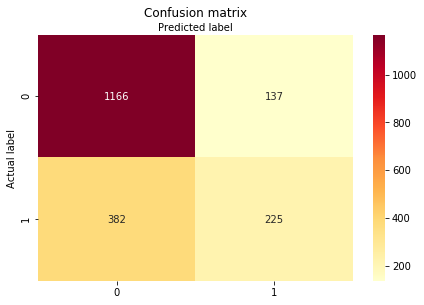

In [66]:
import seaborn as sns
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlOrRd" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

<H3> ROC Curve </H3>

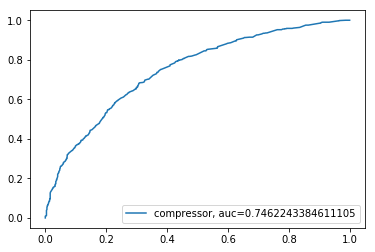

In [67]:
y_pred_proba = classifier.predict_proba(x_test)[::,1]
fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
auc = metrics.roc_auc_score(y_test, y_pred_proba)
plt.plot(fpr,tpr,label="compressor, auc="+str(auc))
plt.legend(loc=4)
plt.show()

# Method 2 Logistic Regrission without using Logit 

In [68]:
X.head()

,Intercept,occ_2,occ_3,occ_4,occ_5,occ_6,occ_husb_2,occ_husb_3,occ_husb_4,occ_husb_5,occ_husb_6,rate_marriage,age,yrs_married,children,religious,educ
0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,32.0,9.0,3.0,3.0,17.0
1,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,3.0,27.0,13.0,3.0,1.0,14.0
2,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,22.0,2.5,0.0,1.0,16.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,4.0,37.0,16.5,4.0,3.0,16.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,5.0,27.0,9.0,1.0,1.0,14.0


In [71]:
X_train,X_test,y_train,y_test = train_test_split(X,y ,test_size=0.3,random_state=0)

In [73]:
classifier1 = LogisticRegression()
classifier1.fit(X_train,y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [75]:
predicted = classifier1.predict(X_test)

In [76]:
count_missmatch=(y_test!=predicted).sum()
count_missmatch

516

In [77]:
cm1 = metrics.confusion_matrix(y_test,predicted)
cm1

array([[1169,  134],
       [ 382,  225]], dtype=int64)

Text(0.5, 257.44, 'Predicted label')

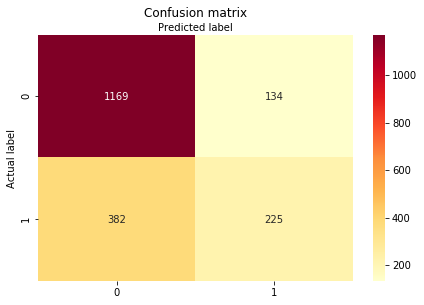

In [79]:
import seaborn as sns
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cm1), annot=True, cmap="YlOrRd" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [80]:
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

         0.0       0.75      0.90      0.82      1303
         1.0       0.63      0.37      0.47       607

   micro avg       0.73      0.73      0.73      1910
   macro avg       0.69      0.63      0.64      1910
weighted avg       0.71      0.73      0.71      1910



In [81]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

         0.0       0.75      0.89      0.82      1303
         1.0       0.62      0.37      0.46       607

   micro avg       0.73      0.73      0.73      1910
   macro avg       0.69      0.63      0.64      1910
weighted avg       0.71      0.73      0.71      1910



by considering all parameter it made no difference to the model as such because those parameters are not having any influence to overall result